In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Balanced LSTM Time Series - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0
(207, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0
(207, 15, 4)
            previous_1d     EMA_12  

In [6]:
r_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
r_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0
(208, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0
(208, 15, 4)
            previous_1d      EMA_12 

## Train Accumulation Phase Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


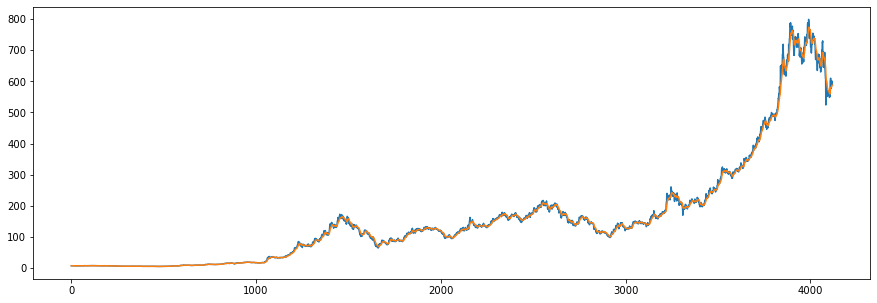

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


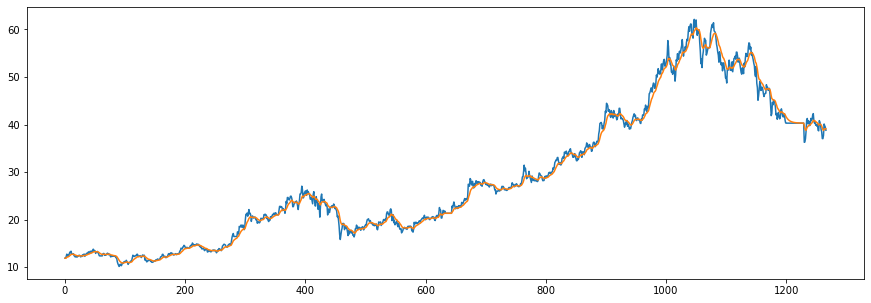

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     4.396951  4.259450 -20.237909   91957609.0     2.0
2000-01-25     4.523540  4.300079 -16.033642  115224048.0     2.0
2000-01-26     4.400991  4.315604 -35.231971  105394663.0     2.0
2000-01-27     4.399644  4.328533 -51.735021   77180955.0     2.0
2000-01-28     4.302682  4.324556 -63.091500   43145413.0     2.0


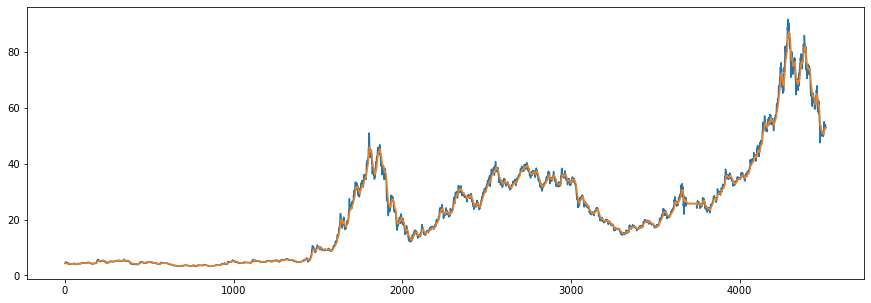

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-06-30        2.575  2.436754 -19.047606  495757896.0     2.0
2004-07-01        2.525  2.450330 -33.333298  480565876.0     2.0
2004-07-02        2.525  2.461818 -33.333298  480565876.0     2.0
2004-07-05        2.550  2.475385 -27.777775  505227876.0     2.0
2004-07-06        2.550  2.486864 -27.777775  505227876.0     2.0


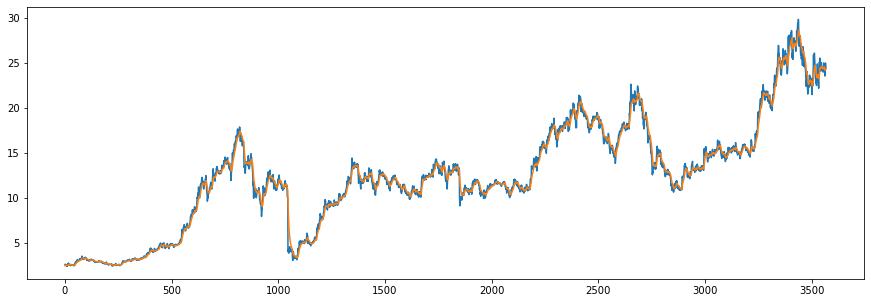

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      50.0000  47.379245 -27.700831  21139400.0     2.0
2000-01-24      48.5000  47.551669 -40.997230  17619200.0     2.0
2000-01-25      47.0000  47.466797 -54.293629  12613700.0     2.0
2000-01-26      49.6875  47.808444 -30.470914  16344500.0     2.0
2000-01-27      50.4375  48.212914 -27.215190  20127300.0     2.0


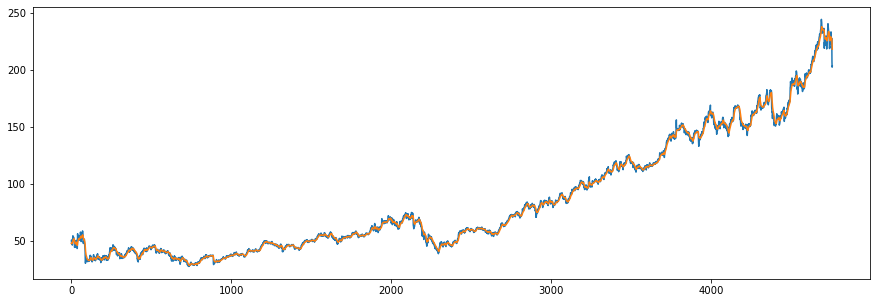

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21     56.28125  56.412106 -36.614173 -25968400.0     2.0
2000-01-24     51.34375  55.632359 -83.112583 -50347200.0     2.0
2000-01-25     51.56250  55.006226 -64.721485 -21792600.0     1.0
2000-01-26     48.75000  54.043730 -88.594164 -38890400.0     2.0
2000-01-27     50.31250  53.469695 -75.331565 -28647200.0     2.0


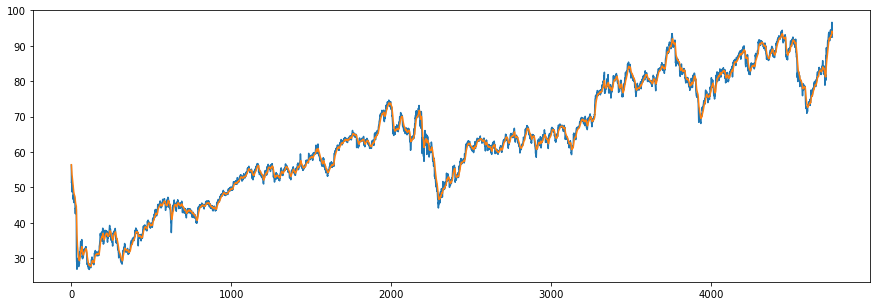

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


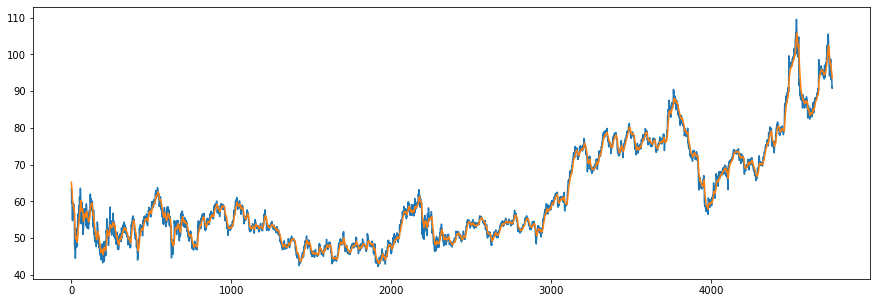

In [10]:
labels = []
sequential = []

train_sets = ['600519.SS','000333.SZ','000858.SZ','2319.HK','COST','PG','WMT']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [11]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(27645, 15, 4)

In [12]:
y = labels
y = np.array(y)
y.shape

(27645,)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 25128, 1.0: 1252, 0.0: 1265})

In [14]:
X = sequential
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:1252]
class_1 = class_1[0:1252]
class_2 = class_2[0:1252]

class_0_labels = class_0_labels[0:1252]
class_1_labels = class_1_labels[0:1252]
class_2_labels = class_2_labels[0:1252]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 15, 4)
y = np.array(y)

print(X.shape)

Counter(y)

(3756, 15, 4)


Counter({0.0: 1252, 1.0: 1252, 2.0: 1252})

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['600519.SS','000333.SZ','WMT','FDP']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 1 0 ... 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/24 [>.............................] - ETA: 0s - loss: 0.3682 - accuracy: 0.3594 - mse: 0.4526 - weighted_accuracy: 0.3595 - weighted_mse: 0.4525WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
24/24 [==============================] - 1s 42ms/step - loss: 0.2882 - accuracy: 0.3502 - mse: 0.5091 - weighted_accuracy: 0.3503 - weighted_mse: 0.5091 - val_loss: 0.2988 - val_accuracy: 0.3391 - val_mse: 0.3475 - val_weighted_accuracy: 0.3391 - val_weighted_mse: 0.3475
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.2059 - accuracy: 0.4720 - mse: 0.7610 - weighted_accuracy: 0.4720 - weighted_mse: 0.7610 - val_loss: 0.2897 - val_accuracy: 0.3338 - val_mse: 0.3664 - val_weighted_accuracy: 0.33

7/7 [==============================] - 0s 3ms/step - loss: 0.1775 - accuracy: 0.5000 - mse: 1.2076 - weighted_accuracy: 0.5000 - weighted_mse: 1.2076
Test loss: 0.17751429975032806
Test accuracy: 0.5


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 57
actual holds but predicted sell: 36
actual predicted holds: 96
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 92.3076923076923%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 44.61538461538461%
Percentage high sells correct: 51.282051282051285%
Percentage mid holds correct: 85.4368932038835%


Capital: 100
Share price: $0.11510518984487804
Shares owned at the moment: 866
Cash capital at the moment: $0.044782584720039154


Price increase fro

7/7 [==============================] - 0s 3ms/step - loss: 0.1979 - accuracy: 0.3394 - mse: 1.2584 - weighted_accuracy: 0.3394 - weighted_mse: 1.2584
Test loss: 0.1978979855775833
Test accuracy: 0.33944955468177795


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 88
actual holds but predicted sell: 50
actual predicted holds: 64
Percentage buys correct: 6.25%
Percentage sells correct: 7.2727272727272725%
Percentage holds correct: 95.5223880597015%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 51.041666666666664%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.56716417910448%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase from previously bought: 922.

2         255.731682  


FDP


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2063 - accuracy: 0.2706 - mse: 1.3185 - weighted_accuracy: 0.2706 - weighted_mse: 1.3185
Test loss: 0.20634602010250092
Test accuracy: 0.2706421911716461


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 107
actual holds but predicted sell: 47
actual predicted holds: 44
Percentage buys correct: 7.627118644067797%
Percentage sells correct: 11.320754716981131%
Percentage holds correct: 93.61702127659575%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 41.52542372881356%
Percentage high sells correct: 50.943396226415096%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
C

Epoch 1/20
24/24 [==============================] - 1s 59ms/step - loss: 0.1419 - accuracy: 0.6791 - mse: 1.5263 - weighted_accuracy: 0.6791 - weighted_mse: 1.5263 - val_loss: 0.1766 - val_accuracy: 0.4920 - val_mse: 1.3015 - val_weighted_accuracy: 0.4920 - val_weighted_mse: 1.3015
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1407 - accuracy: 0.6858 - mse: 1.5374 - weighted_accuracy: 0.6857 - weighted_mse: 1.5373 - val_loss: 0.1742 - val_accuracy: 0.5146 - val_mse: 1.3507 - val_weighted_accuracy: 0.5146 - val_weighted_mse: 1.3507
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1397 - accuracy: 0.6871 - mse: 1.5609 - weighted_accuracy: 0.6871 - weighted_mse: 1.5609 - val_loss: 0.1719 - val_accuracy: 0.5279 - val_mse: 1.3608 - val_weighted_accuracy: 0.5279 - val_weighted_mse: 1.3608
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1385 - accuracy: 0.6901 - mse: 1.5606 - weighted_accuracy: 0.6901 - weighted_ms

Share price: $0.46131450827653353
Shares owned at the moment: 0
Cash capital at the moment: $903.4663108404858


Share price: $0.4476825705939631
Shares owned at the moment: 2012
Cash capital at the moment: $0.2519511423355425


Price increase from previously bought: -14.62893570747471%
Share price: $0.3832424014499147
Shares owned at the moment: 0
Cash capital at the moment: $769.2151826523416


Share price: $0.30474191934944006
Shares owned at the moment: 2517
Cash capital at the moment: $0.07042426954399161


Price increase from previously bought: 22.094531820883432%
Share price: $0.3730964210458252
Shares owned at the moment: 0
Cash capital at the moment: $936.5716358895121


Share price: $0.5181791863817551
Shares owned at the moment: 1802
Cash capital at the moment: $0.24490507147459084


Price increase from previously bought: -6.3345786753283395%
Share price: $0.4866894436161149
Shares owned at the moment: 0
Cash capital at the moment: $874.847492929874


Share price: $0.4426776

7/7 [==============================] - 0s 2ms/step - loss: 0.2593 - accuracy: 0.2560 - mse: 1.9507 - weighted_accuracy: 0.2560 - weighted_mse: 1.9507
Test loss: 0.25927016139030457
Test accuracy: 0.256038635969162


number of predictions: 207
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 68
actual holds but predicted sell: 77
actual predicted holds: 41
Percentage buys correct: 8.0%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 85.41666666666667%
actual buys: 11
actual sells: 10
actual holds: 186


Percentage low buys correct: 58.666666666666664%
Percentage high sells correct: 59.036144578313255%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase from previously bought: 122

7/7 [==============================] - 0s 3ms/step - loss: 0.3215 - accuracy: 0.1606 - mse: 2.2178 - weighted_accuracy: 0.1606 - weighted_mse: 2.2178
Test loss: 0.3214625418186188
Test accuracy: 0.16055046021938324


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 75
actual holds but predicted sell: 104
actual predicted holds: 23
Percentage buys correct: 5.063291139240507%
Percentage sells correct: 7.079646017699115%
Percentage holds correct: 88.46153846153847%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 50.63291139240506%
Percentage high sells correct: 48.67256637168141%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price increase fro

2         255.731682  


FDP


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2880 - accuracy: 0.2294 - mse: 2.1509 - weighted_accuracy: 0.2294 - weighted_mse: 2.1509
Test loss: 0.28804752230644226
Test accuracy: 0.2293577939271927


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 83
actual holds but predicted sell: 83
actual predicted holds: 32
Percentage buys correct: 9.782608695652174%
Percentage sells correct: 9.782608695652174%
Percentage holds correct: 94.11764705882354%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 52.17391304347826%
Percentage high sells correct: 48.35164835164835%
Percentage mid holds correct: 79.41176470588235%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash




RUNNING EPOCHS 40 - 60



Epoch 1/20
24/24 [==============================] - 0s 13ms/step - loss: 0.1253 - accuracy: 0.7307 - mse: 1.7649 - weighted_accuracy: 0.7307 - weighted_mse: 1.7648 - val_loss: 0.1604 - val_accuracy: 0.6290 - val_mse: 1.8158 - val_weighted_accuracy: 0.6290 - val_weighted_mse: 1.8158
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1240 - accuracy: 0.7383 - mse: 1.7744 - weighted_accuracy: 0.7383 - weighted_mse: 1.7744 - val_loss: 0.1604 - val_accuracy: 0.5984 - val_mse: 1.7867 - val_weighted_accuracy: 0.5984 - val_weighted_mse: 1.7867
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1231 - accuracy: 0.7480 - mse: 1.7806 - weighted_accuracy: 0.7480 - weighted_mse: 1.7805 - val_loss: 0.1623 - val_accuracy: 0.6184 - val_mse: 1.8872 - val_weighted_accuracy: 0.6184 - val_weighted_mse: 1.8872
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1223 - accuracy: 0.7423 - mse: 1.7795 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.3810 - accuracy: 0.1971 - mse: 2.6543 - weighted_accuracy: 0.1971 - weighted_mse: 2.6543
Test loss: 0.381035178899765
Test accuracy: 0.19711539149284363


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 57
actual holds but predicted sell: 105
actual predicted holds: 27
Percentage buys correct: 9.375%
Percentage sells correct: 6.956521739130435%
Percentage holds correct: 93.10344827586206%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.125%
Percentage high sells correct: 46.08695652173913%
Percentage mid holds correct: 89.28571428571429%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase from previous

Shares owned at the moment: 0
Cash capital at the moment: $15246.686140084092


Share price: $0.2201193225547804
Shares owned at the moment: 69075
Cash capital at the moment: $0.13089354758994887


Price increase from previously bought: -61.08461055359822%
Share price: $0.0858958574209263
Shares owned at the moment: 0
Cash capital at the moment: $5917.0707899318595


Share price: $0.07746304394622537
Shares owned at the moment: 76176
Cash capital at the moment: $0.018685986164200585


Price increase from previously bought: 575.1193737439797%
Share price: $0.5244061792200057
Shares owned at the moment: 0
Cash capital at the moment: $39837.32909020159


Share price: $0.4239142360592647
Shares owned at the moment: 93717
Cash capital at the moment: $0.1067106683694874


Price increase from previously bought: 31.467094118213424%
Share price: $0.5588403239517155
Shares owned at the moment: 0
Cash capital at the moment: $52228.92004419188


Share price: $0.27423038949320344
Shares owned at th

7/7 [==============================] - 0s 3ms/step - loss: 0.4136 - accuracy: 0.1743 - mse: 2.7811 - weighted_accuracy: 0.1743 - weighted_mse: 2.7811
Test loss: 0.41360291838645935
Test accuracy: 0.17431192100048065


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 71
actual holds but predicted sell: 107
actual predicted holds: 24
Percentage buys correct: 7.792207792207792%
Percentage sells correct: 6.896551724137931%
Percentage holds correct: 96.0%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 51.94805194805195%
Percentage high sells correct: 49.13793103448276%
Percentage mid holds correct: 91.66666666666667%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price increase fr

7/7 [==============================] - 0s 3ms/step - loss: 0.3671 - accuracy: 0.2110 - mse: 2.6810 - weighted_accuracy: 0.2110 - weighted_mse: 2.6810
Test loss: 0.36705705523490906
Test accuracy: 0.2110091745853424


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 82
actual holds but predicted sell: 87
actual predicted holds: 29
Percentage buys correct: 9.89010989010989%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 93.54838709677419%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 48.421052631578945%
Percentage mid holds correct: 80.64516129032258%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price



Price increase from previously bought: 52.46983757889421%
Share price: $0.21830711078648446
Shares owned at the moment: 0
Cash capital at the moment: $56.396274770682886


Share price: $0.2038326250294833
Shares owned at the moment: 275
Cash capital at the moment: $0.18815446489643506


Price increase from previously bought: -16.28506414100159%
Share price: $0.17110760676922832
Shares owned at the moment: 0
Cash capital at the moment: $47.113346198814995


Share price: $0.22460040199569375
Shares owned at the moment: 209
Cash capital at the moment: $0.04277310066797213


Price increase from previously bought: 11.741251070158821%
Share price: $0.2516614701711153
Shares owned at the moment: 0
Cash capital at the moment: $52.49537793645022


Share price: $0.21390184295040116
Shares owned at the moment: 244
Cash capital at the moment: $0.159800119932612


Price increase from previously bought: -7.022570141889095%
Share price: $0.19942735719340043
Shares owned at the moment: 0
Cash capita

Epoch 12/20
24/24 [==============================] - 0s 7ms/step - loss: 0.1012 - accuracy: 0.8013 - mse: 2.0968 - weighted_accuracy: 0.8013 - weighted_mse: 2.0968 - val_loss: 0.1605 - val_accuracy: 0.6370 - val_mse: 2.1727 - val_weighted_accuracy: 0.6370 - val_weighted_mse: 2.1727
Epoch 13/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1003 - accuracy: 0.8076 - mse: 2.1126 - weighted_accuracy: 0.8076 - weighted_mse: 2.1125 - val_loss: 0.1676 - val_accuracy: 0.6250 - val_mse: 2.3829 - val_weighted_accuracy: 0.6250 - val_weighted_mse: 2.3829
Epoch 14/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1012 - accuracy: 0.8069 - mse: 2.1568 - weighted_accuracy: 0.8069 - weighted_mse: 2.1568 - val_loss: 0.1631 - val_accuracy: 0.6316 - val_mse: 2.2532 - val_weighted_accuracy: 0.6316 - val_weighted_mse: 2.2532
Epoch 15/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0989 - accuracy: 0.8132 - mse: 2.1382 - weighted_accuracy: 0.8132 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.4691 - accuracy: 0.1875 - mse: 3.1495 - weighted_accuracy: 0.1875 - weighted_mse: 3.1495
Test loss: 0.4691348671913147
Test accuracy: 0.1875


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 59
actual holds but predicted sell: 105
actual predicted holds: 25
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 6.956521739130435%
Percentage holds correct: 92.5925925925926%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 48.69565217391305%
Percentage mid holds correct: 88.46153846153847%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase fro

7/7 [==============================] - 0s 2ms/step - loss: 0.4116 - accuracy: 0.2019 - mse: 2.9412 - weighted_accuracy: 0.2019 - weighted_mse: 2.9412
Test loss: 0.41159817576408386
Test accuracy: 0.20192307233810425


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 54
actual holds but predicted sell: 110
actual predicted holds: 29
Percentage buys correct: 8.474576271186441%
Percentage sells correct: 6.722689075630252%
Percentage holds correct: 96.66666666666667%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 62.71186440677966%
Percentage high sells correct: 52.54237288135593%
Percentage mid holds correct: 93.33333333333333%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Pri

7/7 [==============================] - 0s 3ms/step - loss: 0.4562 - accuracy: 0.2009 - mse: 3.0655 - weighted_accuracy: 0.2009 - weighted_mse: 3.0655
Test loss: 0.4562496840953827
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 77
actual holds but predicted sell: 95
actual predicted holds: 29
Percentage buys correct: 6.097560975609756%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 90.625%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.32098765432099%
Percentage high sells correct: 46.666666666666664%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase from previou

7/7 [==============================] - 0s 3ms/step - loss: 0.5062 - accuracy: 0.1963 - mse: 3.2151 - weighted_accuracy: 0.1963 - weighted_mse: 3.2151
Test loss: 0.5061696171760559
Test accuracy: 0.19634702801704407


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 76
actual holds but predicted sell: 97
actual predicted holds: 26
Percentage buys correct: 9.411764705882353%
Percentage sells correct: 8.411214953271028%
Percentage holds correct: 96.29629629629629%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 55.95238095238095%
Percentage high sells correct: 49.532710280373834%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price

24/24 [==============================] - 0s 8ms/step - loss: 0.0939 - accuracy: 0.8269 - mse: 2.2386 - weighted_accuracy: 0.8269 - weighted_mse: 2.2386 - val_loss: 0.1671 - val_accuracy: 0.6316 - val_mse: 2.4455 - val_weighted_accuracy: 0.6316 - val_weighted_mse: 2.4455
Epoch 4/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0924 - accuracy: 0.8279 - mse: 2.2487 - weighted_accuracy: 0.8279 - weighted_mse: 2.2487 - val_loss: 0.1670 - val_accuracy: 0.6370 - val_mse: 2.4830 - val_weighted_accuracy: 0.6370 - val_weighted_mse: 2.4830
Epoch 5/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0931 - accuracy: 0.8242 - mse: 2.2756 - weighted_accuracy: 0.8242 - weighted_mse: 2.2756 - val_loss: 0.1716 - val_accuracy: 0.6223 - val_mse: 2.5472 - val_weighted_accuracy: 0.6223 - val_weighted_mse: 2.5472
Epoch 6/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0910 - accuracy: 0.8306 - mse: 2.2994 - weighted_accuracy: 0.8306 - weighted_mse: 2.2993 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.5404 - accuracy: 0.2260 - mse: 3.6227 - weighted_accuracy: 0.2260 - weighted_mse: 3.6227
Test loss: 0.5404242873191833
Test accuracy: 0.22596153616905212


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 61
actual holds but predicted sell: 95
actual predicted holds: 33
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 7.619047619047619%
Percentage holds correct: 94.28571428571429%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 54.411764705882355%
Percentage high sells correct: 48.57142857142857%
Percentage mid holds correct: 85.29411764705883%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Pric

7/7 [==============================] - 0s 3ms/step - loss: 0.4804 - accuracy: 0.2163 - mse: 3.3462 - weighted_accuracy: 0.2163 - weighted_mse: 3.3462
Test loss: 0.4804275333881378
Test accuracy: 0.2163461595773697


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 49
actual holds but predicted sell: 111
actual predicted holds: 33
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 5.932203389830509%
Percentage holds correct: 94.28571428571429%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 63.63636363636363%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 88.57142857142857%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.5352 - accuracy: 0.1918 - mse: 3.5724 - weighted_accuracy: 0.1918 - weighted_mse: 3.5724
Test loss: 0.5351642370223999
Test accuracy: 0.19178082048892975


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 78
actual holds but predicted sell: 95
actual predicted holds: 28
Percentage buys correct: 6.024096385542169%
Percentage sells correct: 8.653846153846153%
Percentage holds correct: 87.5%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 53.65853658536585%
Percentage high sells correct: 44.23076923076923%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase from previously


Share price: $0.33998562237021246
Shares owned at the moment: 315
Cash capital at the moment: $0.09277178946753395


Price increase from previously bought: 15.296718632452698%
Share price: $0.39307024514761824
Shares owned at the moment: 0
Cash capital at the moment: $123.56940191110816


Share price: $0.30411762291313615
Shares owned at the moment: 405
Cash capital at the moment: $0.06305362876851461


Price increase from previously bought: -44.498503079212945%
Share price: $0.169254005157776
Shares owned at the moment: 0
Cash capital at the moment: $68.42241906942333


Share price: $0.2366857456226763
Shares owned at the moment: 288
Cash capital at the moment: $0.06946921955939445


Price increase from previously bought: -12.364403179167239%
Share price: $0.2079913734221277
Shares owned at the moment: 0
Cash capital at the moment: $59.80625559738184


Share price: $0.21444762427044584
Shares owned at the moment: 278
Cash capital at the moment: $0.025870841443136783


Price increase 




RUNNING EPOCHS 100 - 120



Epoch 1/20
24/24 [==============================] - 0s 13ms/step - loss: 0.0820 - accuracy: 0.8562 - mse: 2.5467 - weighted_accuracy: 0.8562 - weighted_mse: 2.5466 - val_loss: 0.1720 - val_accuracy: 0.6343 - val_mse: 2.7872 - val_weighted_accuracy: 0.6343 - val_weighted_mse: 2.7872
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0804 - accuracy: 0.8605 - mse: 2.5720 - weighted_accuracy: 0.8605 - weighted_mse: 2.5719 - val_loss: 0.1808 - val_accuracy: 0.6423 - val_mse: 2.8066 - val_weighted_accuracy: 0.6423 - val_weighted_mse: 2.8066
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0802 - accuracy: 0.8599 - mse: 2.5827 - weighted_accuracy: 0.8598 - weighted_mse: 2.5826 - val_loss: 0.1782 - val_accuracy: 0.6343 - val_mse: 2.7464 - val_weighted_accuracy: 0.6343 - val_weighted_mse: 2.7464
Epoch 4/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0785 - accuracy: 0.8648 - mse: 2.5891 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.5720 - accuracy: 0.2788 - mse: 4.0432 - weighted_accuracy: 0.2788 - weighted_mse: 4.0432
Test loss: 0.5720322728157043
Test accuracy: 0.2788461446762085


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 57
actual holds but predicted sell: 87
actual predicted holds: 45
Percentage buys correct: 9.23076923076923%
Percentage sells correct: 7.368421052631579%
Percentage holds correct: 93.75%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 55.38461538461539%
Percentage high sells correct: 50.526315789473685%
Percentage mid holds correct: 82.97872340425532%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase fro

7/7 [==============================] - 0s 3ms/step - loss: 0.5256 - accuracy: 0.2212 - mse: 3.7285 - weighted_accuracy: 0.2212 - weighted_mse: 3.7285
Test loss: 0.5256219506263733
Test accuracy: 0.2211538404226303


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 54
actual holds but predicted sell: 104
actual predicted holds: 35
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 5.454545454545454%
Percentage holds correct: 92.10526315789474%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 63.333333333333336%
Percentage high sells correct: 53.211009174311926%
Percentage mid holds correct: 86.84210526315789%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price

2        9380.979094  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.5897 - accuracy: 0.2009 - mse: 4.0363 - weighted_accuracy: 0.2009 - weighted_mse: 4.0363
Test loss: 0.5896947383880615
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 77
actual holds but predicted sell: 94
actual predicted holds: 30
Percentage buys correct: 6.097560975609756%
Percentage sells correct: 8.737864077669903%
Percentage holds correct: 88.23529411764706%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 45.63106796116505%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at th

7/7 [==============================] - 0s 3ms/step - loss: 0.7086 - accuracy: 0.2055 - mse: 4.4231 - weighted_accuracy: 0.2055 - weighted_mse: 4.4231
Test loss: 0.7085858583450317
Test accuracy: 0.2054794579744339


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 71
actual holds but predicted sell: 98
actual predicted holds: 30
Percentage buys correct: 8.860759493670885%
Percentage sells correct: 7.4766355140186915%
Percentage holds correct: 90.9090909090909%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 58.97435897435897%
Percentage high sells correct: 49.532710280373834%
Percentage mid holds correct: 87.87878787878788%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

24/24 [==============================] - 0s 13ms/step - loss: 0.0692 - accuracy: 0.8908 - mse: 2.9747 - weighted_accuracy: 0.8908 - weighted_mse: 2.9747 - val_loss: 0.1852 - val_accuracy: 0.6489 - val_mse: 3.2147 - val_weighted_accuracy: 0.6489 - val_weighted_mse: 3.2147
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0679 - accuracy: 0.8955 - mse: 3.0053 - weighted_accuracy: 0.8955 - weighted_mse: 3.0052 - val_loss: 0.1937 - val_accuracy: 0.6449 - val_mse: 3.3085 - val_weighted_accuracy: 0.6449 - val_weighted_mse: 3.3085
Epoch 3/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0679 - accuracy: 0.8901 - mse: 3.0291 - weighted_accuracy: 0.8901 - weighted_mse: 3.0290 - val_loss: 0.1966 - val_accuracy: 0.6410 - val_mse: 3.2055 - val_weighted_accuracy: 0.6410 - val_weighted_mse: 3.2055
Epoch 4/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0662 - accuracy: 0.8978 - mse: 3.0470 - weighted_accuracy: 0.8978 - weighted_mse: 3.0469 -

7/7 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.2933 - mse: 4.7135 - weighted_accuracy: 0.2933 - weighted_mse: 4.7135
Test loss: 0.6468973755836487
Test accuracy: 0.29326921701431274


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 57
actual holds but predicted sell: 84
actual predicted holds: 48
Percentage buys correct: 9.375%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 90.56603773584905%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 54.6875%
Percentage high sells correct: 50.54945054945055%
Percentage mid holds correct: 80.76923076923077%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase from previo

7/7 [==============================] - 0s 3ms/step - loss: 0.5958 - accuracy: 0.2308 - mse: 4.3276 - weighted_accuracy: 0.2308 - weighted_mse: 4.3276
Test loss: 0.5957534313201904
Test accuracy: 0.23076923191547394


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 51
actual holds but predicted sell: 104
actual predicted holds: 38
Percentage buys correct: 8.620689655172415%
Percentage sells correct: 4.587155963302752%
Percentage holds correct: 92.6829268292683%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 62.06896551724138%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 85.36585365853658%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.2055 - mse: 4.7142 - weighted_accuracy: 0.2055 - weighted_mse: 4.7142
Test loss: 0.6717941164970398
Test accuracy: 0.2054794579744339


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 76
actual holds but predicted sell: 93
actual predicted holds: 32
Percentage buys correct: 5.0%
Percentage sells correct: 8.823529411764707%
Percentage holds correct: 86.48648648648648%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.43037974683544%
Percentage high sells correct: 46.07843137254902%
Percentage mid holds correct: 78.37837837837837%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase from 

7/7 [==============================] - 0s 3ms/step - loss: 0.8245 - accuracy: 0.2146 - mse: 5.2687 - weighted_accuracy: 0.2146 - weighted_mse: 5.2687
Test loss: 0.8245152831077576
Test accuracy: 0.21461187303066254


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 71
actual holds but predicted sell: 96
actual predicted holds: 32
Percentage buys correct: 8.860759493670885%
Percentage sells correct: 7.619047619047619%
Percentage holds correct: 91.42857142857143%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 50.476190476190474%
Percentage mid holds correct: 88.57142857142857%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price

24/24 [==============================] - 0s 9ms/step - loss: 0.0570 - accuracy: 0.9151 - mse: 3.5830 - weighted_accuracy: 0.9151 - weighted_mse: 3.5829 - val_loss: 0.2129 - val_accuracy: 0.6423 - val_mse: 3.8177 - val_weighted_accuracy: 0.6423 - val_weighted_mse: 3.8177
Epoch 4/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0557 - accuracy: 0.9234 - mse: 3.6179 - weighted_accuracy: 0.9234 - weighted_mse: 3.6178 - val_loss: 0.2189 - val_accuracy: 0.6410 - val_mse: 4.0080 - val_weighted_accuracy: 0.6410 - val_weighted_mse: 4.0080
Epoch 5/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0567 - accuracy: 0.9168 - mse: 3.6376 - weighted_accuracy: 0.9168 - weighted_mse: 3.6375 - val_loss: 0.2482 - val_accuracy: 0.6277 - val_mse: 4.1203 - val_weighted_accuracy: 0.6277 - val_weighted_mse: 4.1203
Epoch 6/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0555 - accuracy: 0.9194 - mse: 3.7155 - weighted_accuracy: 0.9194 - weighted_mse: 3.7155 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.8040 - accuracy: 0.2692 - mse: 5.6153 - weighted_accuracy: 0.2692 - weighted_mse: 5.6153
Test loss: 0.8040309548377991
Test accuracy: 0.26923078298568726


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 55
actual holds but predicted sell: 91
actual predicted holds: 43
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 91.48936170212765%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 53.96825396825397%
Percentage high sells correct: 51.02040816326531%
Percentage mid holds correct: 80.43478260869566%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.7234 - accuracy: 0.2115 - mse: 5.0957 - weighted_accuracy: 0.2115 - weighted_mse: 5.0957
Test loss: 0.723399817943573
Test accuracy: 0.21153846383094788


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 52
actual holds but predicted sell: 107
actual predicted holds: 34
Percentage buys correct: 8.474576271186441%
Percentage sells correct: 4.464285714285714%
Percentage holds correct: 91.89189189189189%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 62.71186440677966%
Percentage high sells correct: 52.252252252252255%
Percentage mid holds correct: 83.78378378378379%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price 

Cash capital at the moment: $75.6168529036629


Share price: $0.2376717024317323
Shares owned at the moment: 317
Cash capital at the moment: $0.06773292620889038


Price increase from previously bought: -17.84105362843873%
Share price: $0.19580555509925213
Shares owned at the moment: 0
Cash capital at the moment: $61.967400400014036


Share price: $0.2488359272664431
Shares owned at the moment: 248
Cash capital at the moment: $0.0863843355404299


Price increase from previously bought: 46.38624039934858%
Share price: $0.3652632779745961
Shares owned at the moment: 0
Cash capital at the moment: $90.42256771766158


Share price: $0.7157417577904692
Shares owned at the moment: 125
Cash capital at the moment: $0.7088117646124488


Price increase from previously bought: -43.051646667451685%
Share price: $0.4087240538243402
Shares owned at the moment: 0
Cash capital at the moment: $51.65881959915285


Share price: $0.6674961837820004
Shares owned at the moment: 77
Cash capital at the moment:

7/7 [==============================] - 0s 3ms/step - loss: 0.9385 - accuracy: 0.2523 - mse: 6.4459 - weighted_accuracy: 0.2523 - weighted_mse: 6.4459
Test loss: 0.9385277032852173
Test accuracy: 0.25229358673095703


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 72
actual holds but predicted sell: 87
actual predicted holds: 39
Percentage buys correct: 10.0%
Percentage sells correct: 8.24742268041237%
Percentage holds correct: 95.1219512195122%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 55.0%
Percentage high sells correct: 43.75%
Percentage mid holds correct: 80.48780487804878%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase from previously bought: -38.85




RUNNING EPOCHS 160 - 180



Epoch 1/20
24/24 [==============================] - 0s 13ms/step - loss: 0.0496 - accuracy: 0.9294 - mse: 4.1711 - weighted_accuracy: 0.9294 - weighted_mse: 4.1711 - val_loss: 0.2265 - val_accuracy: 0.6516 - val_mse: 4.3558 - val_weighted_accuracy: 0.6516 - val_weighted_mse: 4.3558
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0478 - accuracy: 0.9397 - mse: 4.2016 - weighted_accuracy: 0.9397 - weighted_mse: 4.2015 - val_loss: 0.2476 - val_accuracy: 0.6370 - val_mse: 4.6022 - val_weighted_accuracy: 0.6370 - val_weighted_mse: 4.6022
Epoch 3/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0479 - accuracy: 0.9338 - mse: 4.2498 - weighted_accuracy: 0.9338 - weighted_mse: 4.2498 - val_loss: 0.2355 - val_accuracy: 0.6383 - val_mse: 4.5828 - val_weighted_accuracy: 0.6383 - val_weighted_mse: 4.5828
Epoch 4/20
24/24 [==============================] - 0s 7ms/step - loss: 0.0466 - accuracy: 0.9377 - mse: 4.2951 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.8843 - accuracy: 0.2740 - mse: 6.4125 - weighted_accuracy: 0.2740 - weighted_mse: 6.4125
Test loss: 0.8842761516571045
Test accuracy: 0.2740384638309479


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 51
actual holds but predicted sell: 94
actual predicted holds: 44
Percentage buys correct: 10.344827586206897%
Percentage sells correct: 6.930693069306931%
Percentage holds correct: 89.79591836734694%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 55.172413793103445%
Percentage high sells correct: 51.48514851485149%
Percentage mid holds correct: 77.08333333333333%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Pric

7/7 [==============================] - 0s 2ms/step - loss: 0.7840 - accuracy: 0.2308 - mse: 5.7393 - weighted_accuracy: 0.2308 - weighted_mse: 5.7393
Test loss: 0.784028172492981
Test accuracy: 0.23076923191547394


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 50
actual holds but predicted sell: 105
actual predicted holds: 38
Percentage buys correct: 8.771929824561404%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 92.6829268292683%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 61.40350877192982%
Percentage high sells correct: 53.211009174311926%
Percentage mid holds correct: 85.36585365853658%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.8948 - accuracy: 0.2466 - mse: 6.4150 - weighted_accuracy: 0.2466 - weighted_mse: 6.4150
Test loss: 0.8947572708129883
Test accuracy: 0.24657534062862396


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 70
actual holds but predicted sell: 91
actual predicted holds: 40
Percentage buys correct: 5.333333333333333%
Percentage sells correct: 9.900990099009901%
Percentage holds correct: 93.02325581395348%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.054054054054056%
Percentage high sells correct: 48.51485148514851%
Percentage mid holds correct: 83.72093023255815%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Pri

7/7 [==============================] - 0s 3ms/step - loss: 1.0972 - accuracy: 0.2100 - mse: 7.2253 - weighted_accuracy: 0.2100 - weighted_mse: 7.2253
Test loss: 1.097198247909546
Test accuracy: 0.21004566550254822


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 70
actual holds but predicted sell: 98
actual predicted holds: 31
Percentage buys correct: 10.0%
Percentage sells correct: 6.60377358490566%
Percentage holds correct: 93.93939393939394%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 59.49367088607595%
Percentage high sells correct: 50.943396226415096%
Percentage mid holds correct: 90.9090909090909%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from p

24/24 [==============================] - 0s 13ms/step - loss: 0.0419 - accuracy: 0.9471 - mse: 4.9182 - weighted_accuracy: 0.9471 - weighted_mse: 4.9181 - val_loss: 0.2534 - val_accuracy: 0.6516 - val_mse: 5.1030 - val_weighted_accuracy: 0.6516 - val_weighted_mse: 5.1030
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0403 - accuracy: 0.9507 - mse: 4.9576 - weighted_accuracy: 0.9507 - weighted_mse: 4.9575 - val_loss: 0.2735 - val_accuracy: 0.6383 - val_mse: 5.3995 - val_weighted_accuracy: 0.6383 - val_weighted_mse: 5.3995
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0405 - accuracy: 0.9491 - mse: 5.0114 - weighted_accuracy: 0.9491 - weighted_mse: 5.0113 - val_loss: 0.2573 - val_accuracy: 0.6489 - val_mse: 5.3911 - val_weighted_accuracy: 0.6489 - val_weighted_mse: 5.3911
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0393 - accuracy: 0.9521 - mse: 5.0719 - weighted_accuracy: 0.9521 - weighted_mse: 5.0718 -

7/7 [==============================] - 0s 2ms/step - loss: 1.0085 - accuracy: 0.2788 - mse: 7.3776 - weighted_accuracy: 0.2788 - weighted_mse: 7.3776
Test loss: 1.00846529006958
Test accuracy: 0.2788461446762085


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 53
actual holds but predicted sell: 91
actual predicted holds: 45
Percentage buys correct: 10.0%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 90.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 55.0%
Percentage high sells correct: 52.04081632653061%
Percentage mid holds correct: 79.59183673469387%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase from previously bought: 61.39250

7/7 [==============================] - 0s 2ms/step - loss: 0.8912 - accuracy: 0.2356 - mse: 6.6067 - weighted_accuracy: 0.2356 - weighted_mse: 6.6067
Test loss: 0.8911678791046143
Test accuracy: 0.23557692766189575


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 54
actual holds but predicted sell: 100
actual predicted holds: 39
Percentage buys correct: 8.19672131147541%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 92.85714285714286%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 62.295081967213115%
Percentage high sells correct: 51.92307692307692%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.9860 - accuracy: 0.2466 - mse: 7.3791 - weighted_accuracy: 0.2466 - weighted_mse: 7.3791
Test loss: 0.9859817028045654
Test accuracy: 0.24657534062862396


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 68
actual holds but predicted sell: 93
actual predicted holds: 40
Percentage buys correct: 5.47945205479452%
Percentage sells correct: 9.70873786407767%
Percentage holds correct: 93.02325581395348%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.77777777777778%
Percentage high sells correct: 45.63106796116505%
Percentage mid holds correct: 81.3953488372093%


Capital: 100
Share price: $0.2521008983715609
Shares owned at the moment: 395
Cash capital at the moment: $0.14630054237733248


Price in

7/7 [==============================] - 0s 3ms/step - loss: 1.2126 - accuracy: 0.2237 - mse: 8.3165 - weighted_accuracy: 0.2237 - weighted_mse: 8.3165
Test loss: 1.2125539779663086
Test accuracy: 0.22374428808689117


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 72
actual holds but predicted sell: 93
actual predicted holds: 34
Percentage buys correct: 9.75609756097561%
Percentage sells correct: 6.930693069306931%
Percentage holds correct: 94.44444444444444%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 56.79012345679013%
Percentage high sells correct: 49.504950495049506%
Percentage mid holds correct: 91.66666666666667%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

In [20]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     2765.377267
1    12074.749570
2     3071.981805
3       83.459239
Name: Profit gained, dtype: float64

In [21]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 

    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3])     

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


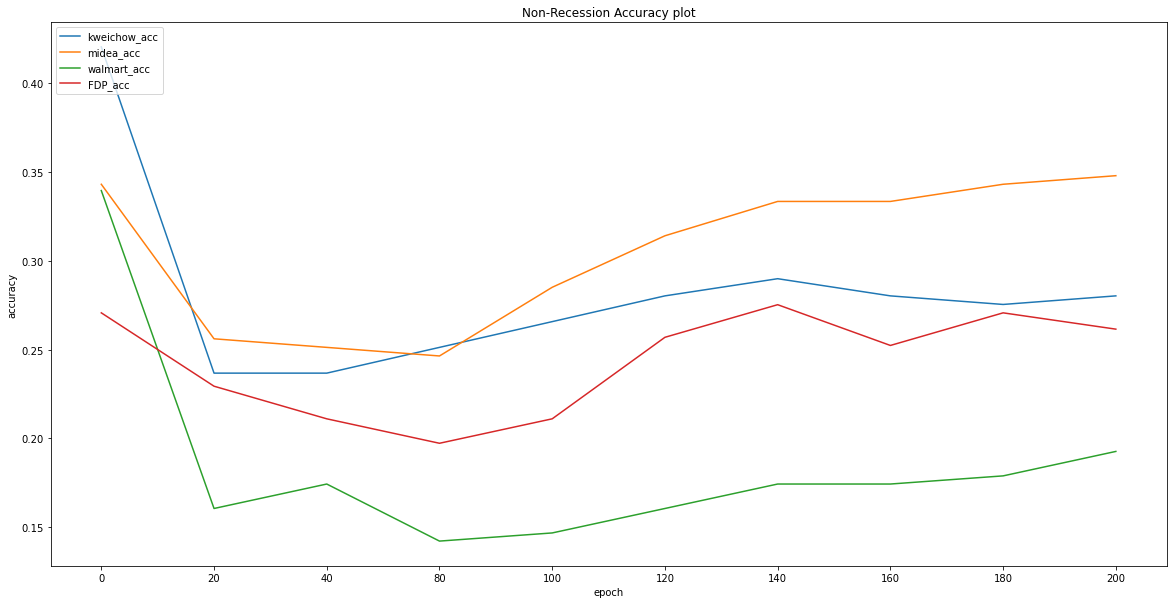

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

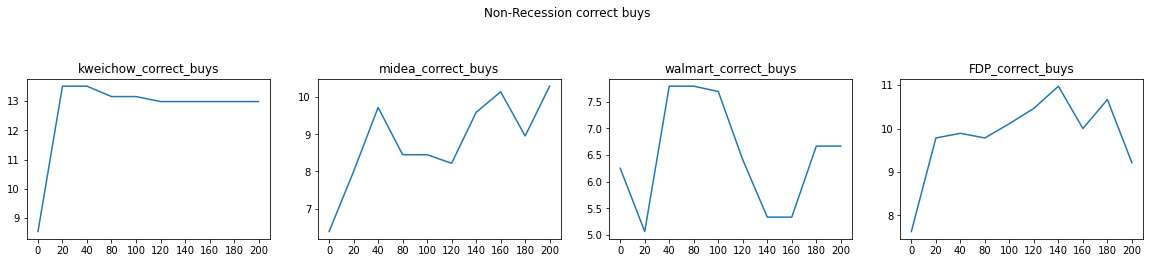

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")

Text(0.5, 1.0, 'FDP_correct_sells')

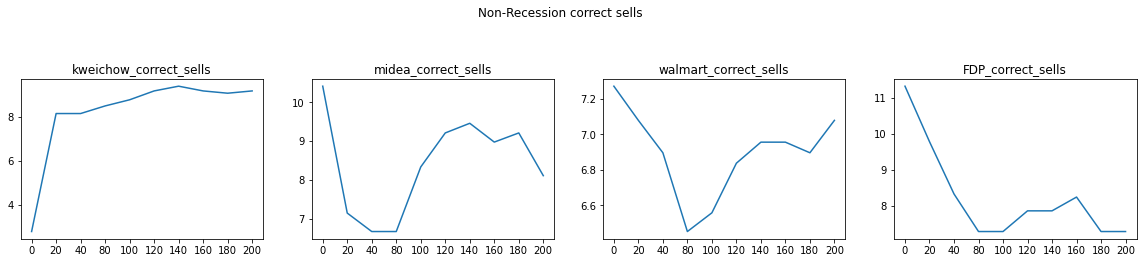

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

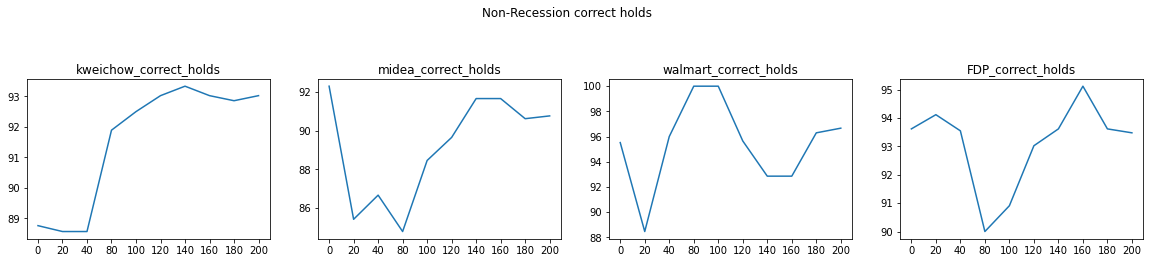

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

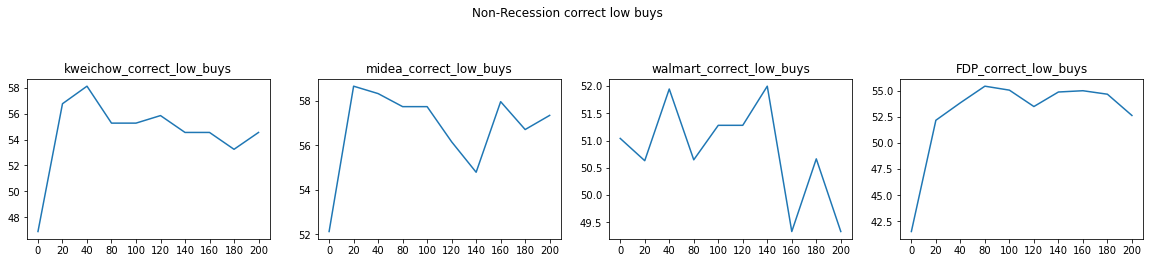

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

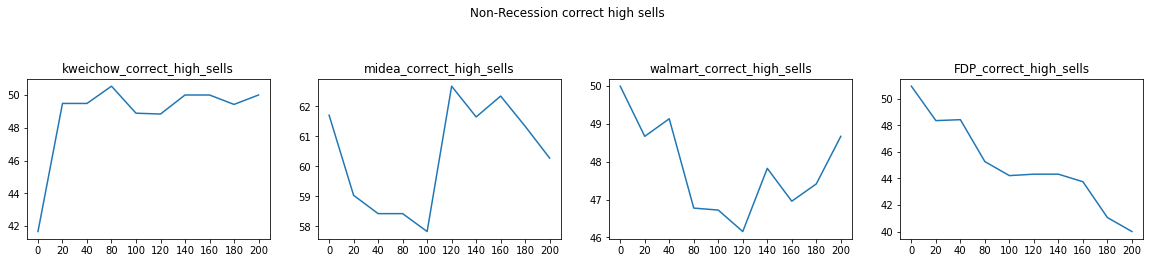

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

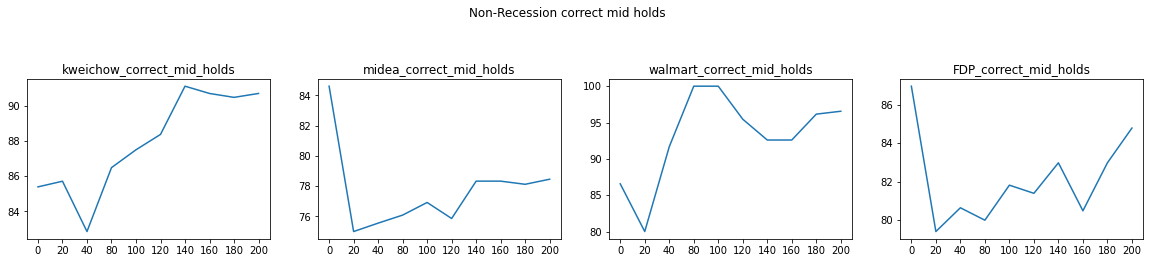

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

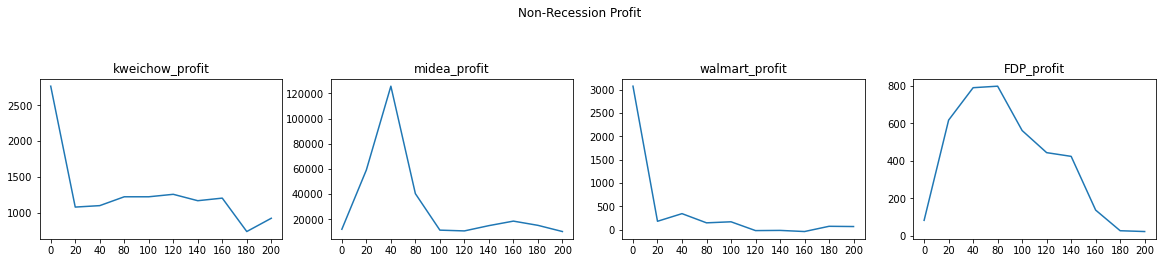

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")

In [30]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 
    
    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3]) 

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


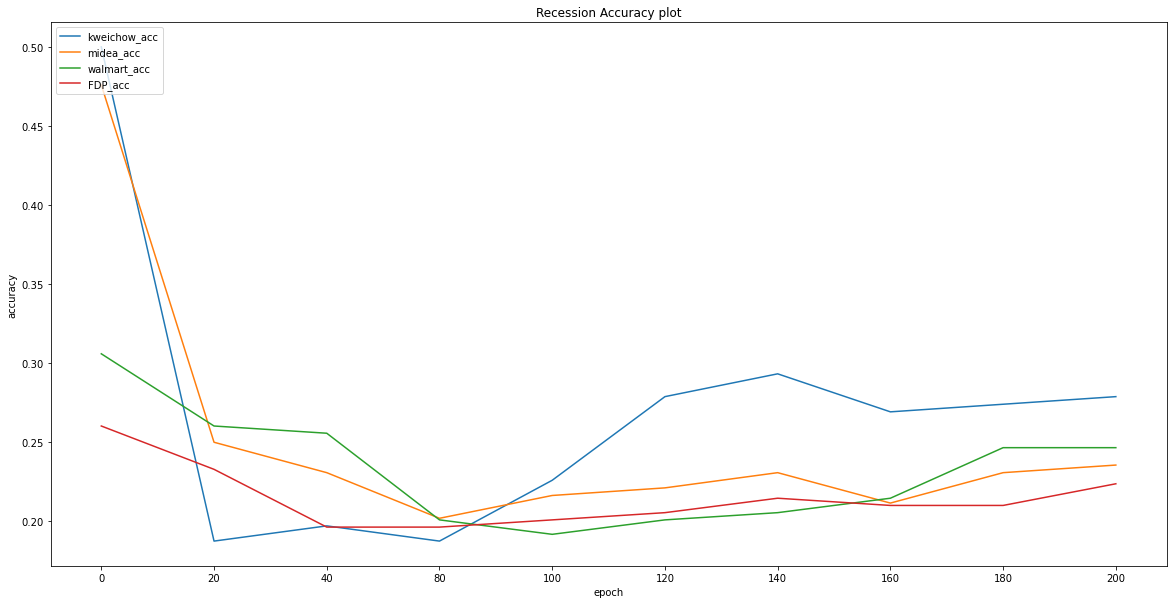

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

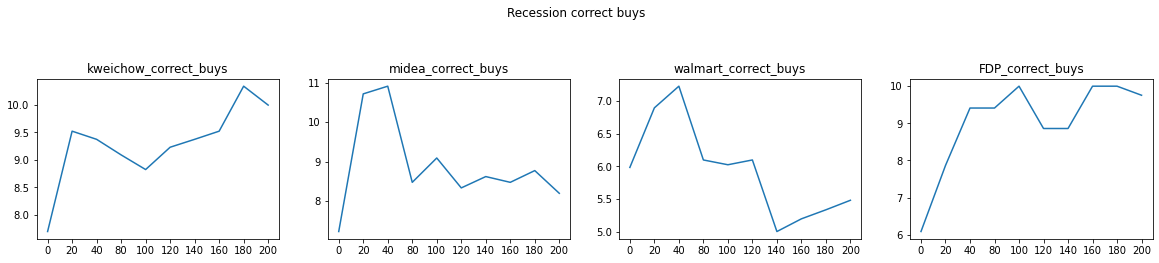

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")

Text(0.5, 1.0, 'FDP_correct_sells')

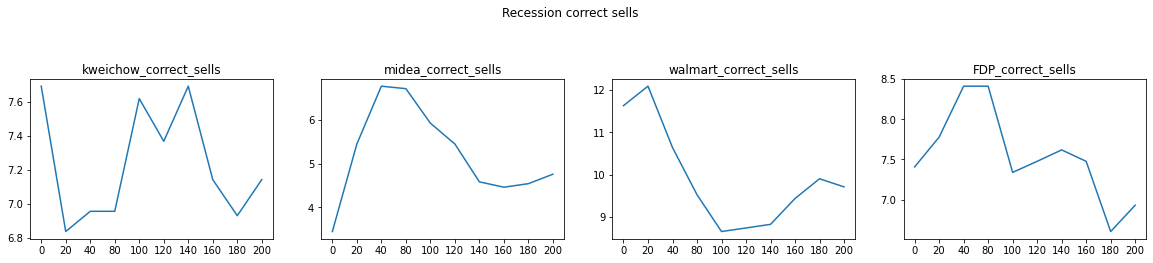

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

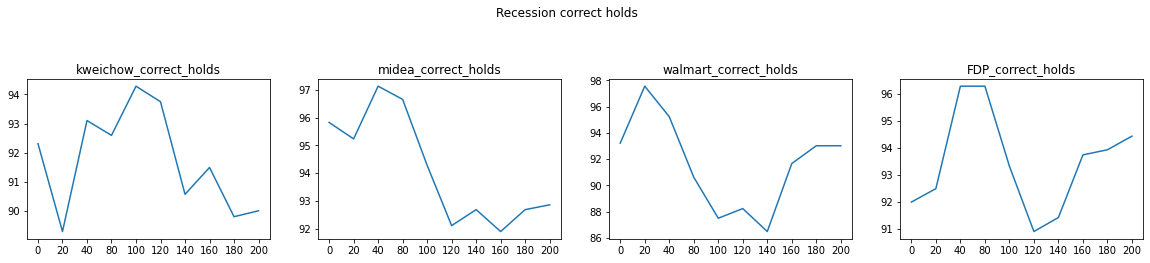

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

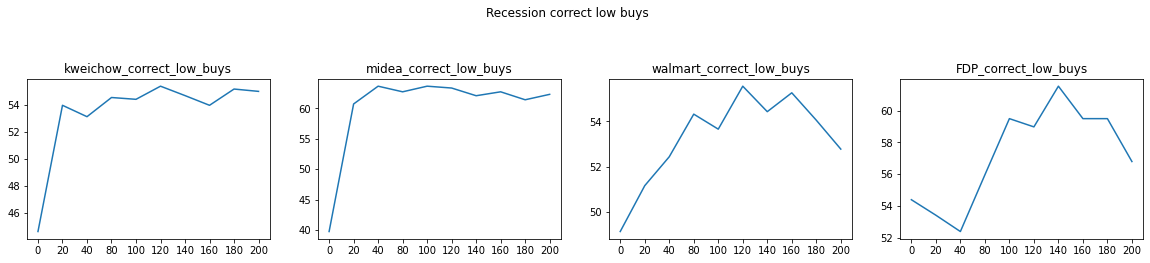

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

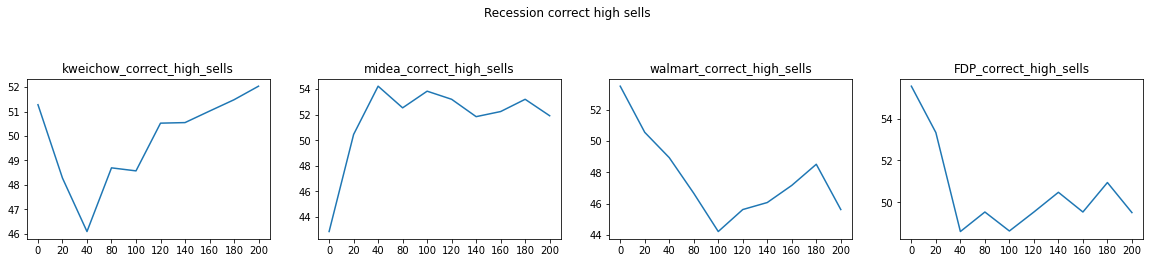

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

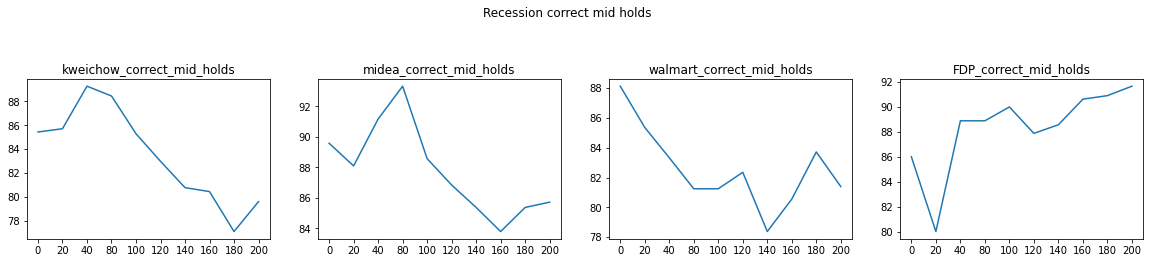

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

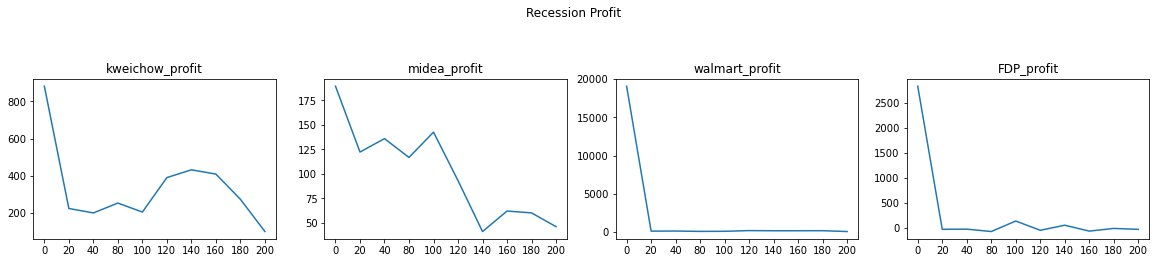

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")